In [12]:
import torch

In [28]:
cat = torch.distributions.Categorical(torch.tensor([0.5,0.5]))
mvn = torch.distributions.MultivariateNormal(torch.tensor([[-2.5],[2.5]]), torch.eye(1).unsqueeze(-1).repeat(2,1,1))
p_distribution = torch.distributions.MixtureSameFamily(cat, mvn)
p_samples = p_distribution.sample([5000])

In [29]:
cat = torch.distributions.Categorical(torch.tensor([0.5,0.5]))
mvn = torch.distributions.MultivariateNormal(torch.tensor([[-2.5],[2.5]]), torch.eye(1).unsqueeze(-1).repeat(2,1,1))
q_distribution = torch.distributions.Laplace(torch.tensor([0.]), torch.tensor([1.5]))
q_samples = q_distribution.sample([5000])

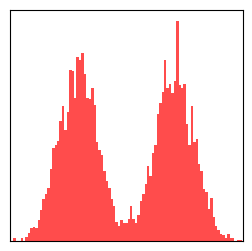

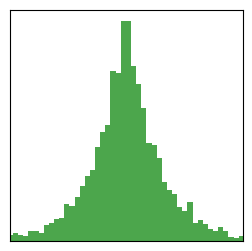

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize =(3,3))
plt.hist(p_samples.numpy(), bins = 100, density = True, color = 'Red', alpha = .7)
plt.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
plt.xlim(-6,6)
plt.show()
plt.figure(figsize =(3,3))
plt.hist(q_samples.numpy(), bins = 100, density = True, color = 'Green', alpha = .7)
plt.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
plt.xlim(-6,6)
plt.show()

In [31]:
from tqdm import tqdm
class BinaryClassifier(torch.nn.Module):
    def __init__(self, label_0_samples, label_1_samples,hidden_dims = []):
        super().__init__()
        self.label_0_samples = label_0_samples
        self.label_1_samples = label_1_samples
        assert label_0_samples.shape[-1]==label_1_samples.shape[-1],'mismatch in sample dimensions'
        self.p = label_0_samples.shape[-1]
        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.SiLU(), ])
        network.pop()
        self.logit_r = torch.nn.Sequential(*network)
        self.w = torch.distributions.Dirichlet(torch.ones(self.label_0_samples.shape[0] + self.label_1_samples.shape[0])).sample()

    def loss(self, samples, labels, w):
        label_0_samples = samples[labels == 0]
        label_0_w = w[labels == 0]
        label_1_samples = samples[labels == 1]
        label_1_w = w[labels == 1]
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.sum(label_1_w * log_sigmoid(self.logit_r(label_1_samples))) - torch.sum(label_0_w * log_sigmoid(-self.logit_r(label_0_samples)))

    def train(self, epochs, batch_size=None, lr=5e-3, weight_decay=5e-6, verbose = False):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        if batch_size is None:
            batch_size = self.label_1_samples.shape[0] + self.label_0_samples.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        samples = torch.cat([self.label_0_samples, self.label_1_samples], dim = 0).to(device)
        labels= torch.cat([torch.zeros(self.label_0_samples.shape[0]), torch.ones(self.label_1_samples.shape[0])], dim = 0).long().to(device)
        dataset = torch.utils.data.TensorDataset(samples, labels, self.w.to(device))

        if verbose:
            pbar = tqdm(range(epochs))
        else:
            pbar = range(epochs)
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for batch in dataloader:
                optimizer.zero_grad()
                batch_loss = self.loss(batch[0], batch[1], batch[2])
                batch_loss.backward()
                optimizer.step()
            if verbose: 
                with torch.no_grad():
                    iteration_loss = torch.tensor([self.loss(batch[0], batch[1],batch[2]) for batch in dataloader]).mean().item()
                pbar.set_postfix_str('loss = ' + str(round(iteration_loss, 6)) + '; device = ' + str(device))
        self.to(torch.device('cpu'))


In [38]:
classif = BinaryClassifier(q_samples, p_samples, [16,16])
classif.train(200,2500, verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.10it/s, loss = 164.575958; device = cpu]


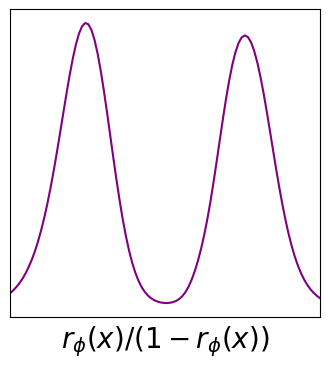

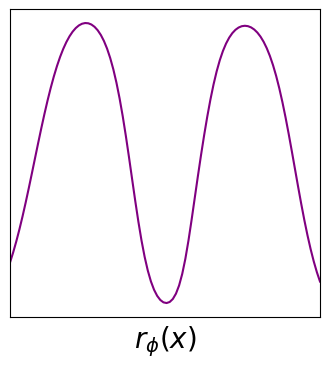

In [49]:
ratio_classif = lambda x: torch.exp(classif.logit_r(x))
fig = plt.figure(figsize=(4,4))
with torch.no_grad():
    ratio = lambda x: torch.exp(p_distribution.log_prob(x.unsqueeze(-1)) - q_distribution.log_prob(x))
    tt = torch.linspace(-6,6,100)
    ax =  fig.add_subplot(111)
    ax.plot(tt.numpy(), ratio_classif(tt.unsqueeze(-1)).numpy(), color = 'purple')
    ax.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
    ax.set_xlim(-6,6)
plt.title(r'$r_\phi(x)/(1-r_\phi(x))$', fontsize = 20, y=-0.125)
plt.show()
post_classif = lambda x: torch.sigmoid(classif.logit_r(x))

fig = plt.figure(figsize=(4,4))
with torch.no_grad():
    post = lambda x: torch.exp(p_distribution.log_prob(x.unsqueeze(-1)))/(torch.exp(p_distribution.log_prob(x.unsqueeze(-1))) + torch.exp(q_distribution.log_prob(x)))
    tt = torch.linspace(-6,6,100)
    ax = fig.add_subplot(111)
    ax.plot(tt.numpy(), post_classif(tt.unsqueeze(-1)).numpy(), color = 'purple')
    ax.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
    ax.set_xlim(-6,6)
plt.title(r'$r_\phi(x)$', fontsize = 20, y=-0.125)
plt.show()

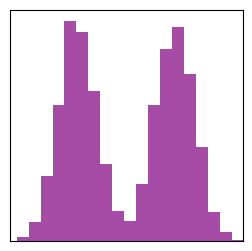

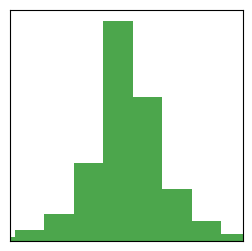

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (3,3))
plt.hist(p_samples.numpy(), bins = 20, density = True, color = 'Purple', alpha = .7)
plt.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
plt.xlim(-6,6)
plt.show()
plt.figure(figsize = (3,3))
plt.hist(q_samples.numpy(), bins = 20, density = True, color = 'Green', alpha = .7)
plt.tick_params(bottom = False, left = False, labelbottom= False, labelleft = False)
plt.xlim(-6,6)
plt.show()